In [ ]:
#一些常用的命令
!nvidia-smi

In [ ]:
#一些常用的命令
!git status
!git add .
!git commit -m "correct and optimize some code"
!git push

0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍
0.这是简化程序，原始带有更多测试和原始模型的程序在mainTestCSVMLP3(hmcnf_keras).ipynb
0.这是简化程序，只训练和测试5label模型,编号为0
0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍
reading data france,读取数据并且把数据进行onehot处理
x0.shape: (1482835, 48) y0.shape: (1482835,) y0.type: <class 'numpy.ndarray'>
准备字典，用于保存训练后的数据
5label 模型
x.shape: (1482835, 48) y.shape: (1482835,) y.type: <class 'numpy.ndarray'>
y.shape: (1482835, 1) y.type: <class 'numpy.ndarray'>
keras

mat1num
 [[272399   9467  14267     83    351]
 [ 27714 249760  13364   4414   1315]
 [ 10280   4871 265844   9204   6368]
 [     0   1398   2319 280895  11955]
 [     0      0    305   6917 289345]]
mat2acc
 [[0.878 0.036 0.048 0.    0.001]
 [0.089 0.941 0.045 0.015 0.004]
 [0.033 0.018 0.898 0.031 0.021]
 [0.    0.005 0.008 0.932 0.039]
 [0.    0.    0.001 0.023 0.935]]
纯决策树的识别
               precision    recall  f1-score   support

           0       0.83      0.76      0.79    296567
           1       0.62      0.56  

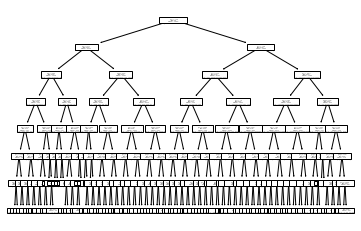

In [2]:
########################################################################################################################
print("0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍")
print("0.这是简化程序，原始带有更多测试和原始模型的程序在mainTestCSVMLP3(hmcnf_keras).ipynb")
print("0.这是简化程序，只训练和测试5label模型,编号为0")
########################################################################################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
#import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler

import pickle  

########################################################################################################################
#######开始为功能函数
#######函数用于决策树分析

def dtFitAndSave(x,y,saveName):
    str1="dtFitAndSave,用于决策树拟合和识别"
    
    dt = tree.DecisionTreeClassifier(max_depth=7,min_samples_leaf=100)
    dt = dt.fit(x, y)
    tree.plot_tree(dt)
    #data=tree.export_graphviz(dt, out_file=None,class_names=None,filled=True) 
    #graph = graphviz.Source(data)
    #graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print("纯决策树的识别\n",tmp1)
    mat1num = confusion_matrix(y,yPredict)
    mat2acc = confusion_matrix(y,yPredict,normalize='pred')
    print(mat1num)
    print(np.around(mat2acc , decimals=3))
    #text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    return dt,yPredict

########################################################################################################################
###简单模型3，resnet_like

def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model

def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

def kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName):
    str1="kerasFitAndSaveSimple3LikeResnet,用于resnet_like的神经网络拟合和识别"
    
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    hierarchy = [1,1,1]#三层，对于当前数据集已经足够了
    global_models = []
    label_size = num_labels
    features = layers.Input(shape=(features_size,))
    for i in range(len(hierarchy)):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

    p_glob = sigmoid_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[features], outputs=[p_glob])
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    if 1:
       build_model = keras.models.load_model(saveName)
    
    #build_model.fit([x],[yOneHot],epochs=10, batch_size=10000*1)
    build_model.fit(x,yOneHot,epochs=15000, batch_size=20000*1)#GPU用这个
    #saveName = "KerasSimple3_likeResnet.h5"
    build_model.save(saveName)
    #plot_model(build_model, to_file='KerasSimple3_likeResnet.png', show_shapes=True)
    return build_model
########################################################################################################################
def getKerasResnetRVL(x,enc,saveName):
    model_name = saveName 
    model = keras.models.load_model(model_name)
    y= model.predict([x], batch_size=2560)
    nSamples = y.shape[0]
    ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(y.shape[0]):
        tmp = y[i]
        index=  np.argmax(tmp)
        y[i] = [0]*y.shape[1]
        y[i,index]=1
   

    ###  
    y= enc.inverse_transform(y)
    y= y.reshape(-1,nSamples)[0]
    
    
    return y

def string2int(inputString):
     #print(inputString)
     tmp = 0
     try:
         strTmp=[str(ord(x)) for x in inputString]
         tmp=tmp.join(strTmp)
         tmp = float(tmp)/(len(inputString)*128)
     except:
         #print(inputString)
         strTmp = inputString
         tmp= "0"
         tmp = 0
     return tmp
########################################################################################################################
########################################################################################################################
print("0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍")
########################################################################################################################

print("reading data france,读取数据并且把数据进行onehot处理")
file1 = "./trainData/france_0_allSamples1.csv"

xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)
h,w = xyData.shape
#x = xyData[:,1:23]#简单处理与SUMO数据库一致
x0rigin = xyData[:,1:w-1]#用所有的数据
y0rigin  = xyData[:,w-1]

x0rigin[:,6] = [string2int(inputString) for inputString in x0rigin[:,6] ]#字符串vehLaneID 变为整数

x0rigin =x0rigin.astype(np.float32)#GPU 加这个
y0rigin =y0rigin.astype(np.int64)#GPU 加这个


ros = RandomOverSampler(random_state=0)
x0,y0= ros.fit_resample(x0rigin , y0rigin)#对数据不平衡进行处理，保证样本数一致

x0=x0.astype(np.float32)#GPU 加这个
y0=y0.astype(np.int64)#GPU 加这个
yl5 = y0
print("x0.shape:",x0.shape,"y0.shape:",y0.shape,"y0.type:", type(y0) )
del xyDataTmp #节省内存
del xyData #节省内存




########################################################################################################################
print("准备字典，用于保存训练后的数据")

xFloors=  dict()
yFloors =  dict()
dtModeFloors=  dict()
dtPredictLabel = dict()
kerasPredictLabel = dict()
kerasModelNameFloors =dict()
encFloors= dict()
########################################################################################################################
###现在暂时不训练多层模型，只训练5label模型
if 1:
    print("5label 模型")
    x=x0
    y=yl5
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    
    num_labels = 5 
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    y= y.reshape(nSamples,-1)
    
    print("y.shape:",y .shape,"y.type:", type(y) )
    enc.fit(y)
    yOneHot=enc.transform(y).toarray()
    saveName = "hybrid2_KerasSimple3_likeResnet_5label.h5"
    if 0:
        kerasModel3_5label = kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName)     
    yKeras_5label=getKerasResnetRVL(x,enc,saveName)
    
    print('keras\n')
    mat1num = confusion_matrix(y, yKeras_5label)
    mat2acc = confusion_matrix(y, yKeras_5label,normalize='pred')
    print('mat1num\n',mat1num)
    print('mat2acc\n',np.around(mat2acc , decimals=3))
    
    
    
    
    dt_5label,dt_PredictLabel = dtFitAndSave(x,yl5,"5label")
    enc_5label = enc
    
    xFloors[0] =  x.copy()
    yFloors[0] =  y.copy()
    dtModeFloors[0] =  dt_5label
    dtPredictLabel[0] = dt_PredictLabel.copy()
    kerasPredictLabel[0] = yKeras_5label.copy()
    kerasModelNameFloors[0] =saveName
    encFloors[0] = enc_5label


In [3]:
########################################################################################################################
print("1.接编号为0的主程序,对于输入的一个样本识别与各个类别的距离，并转换为概率")
print("2.对较低概率的样本进行蒙特卡洛模拟分析，原始对应程序为mainSimSumoFranceDatra")
print("3.程序编号为1")
########################################################################################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
#import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler
import pickle

import warnings
warnings.filterwarnings("ignore")
########################################################################################################################
###自定义log,用于记录
def log(info,logtype=0):
    
    #*args
    if logtype == -1:
        return
    if logtype == 0:
        print(info)        


    
########################################################################################################################
print("1.1 主程序开始，接编号为0的主程序,对于输入的一个样本识别与各个类别的距离，并转换为概率")
########################################################################################################################
logtype=0

xi=x0
yi=yl5
modeSaveName = "hybrid2_KerasSimple3_likeResnet_5label.h5"
model = keras.models.load_model(modeSaveName)
yout= model.predict([xi], batch_size=2560)
#log(xi,logtype)
#log(yi,logtype)
#log(yout,logtype)
ymax1=np.max(yout,axis=1)
index = np.where(ymax1<0.95)[0]#提取最大值小于0.95的例子
ylowpraPredictNN=yout[index]#对较低概率的样本
xlowpra=xi[index]
ylowpraLabel = yi[index]
#log(xi,logtype)
#log(yi,logtype)
#log(ylowpra)
#log(xlowpra)
#log(index)

    
#######保存为pickle文件

##保存低概率的样本
fpk=open('lowprobSamples.pkf','wb+')  
pickle.dump([index,xlowpra,ylowpraLabel,ylowpraPredictNN],fpk)  
fpk.close() 
del xlowpra,ylowpraLabel
fpk=open('lowprobSamples.pkf','rb')   
[index1,xlowprob1,ylowprobLabel1,ylowprobPredictNN1]=pickle.load(fpk)  
fpk.close()  


log(index1)
#log(ylowprobLabel1)
log(np.round(ylowprobPredictNN1,2))

##保存所有的的样本
fpk=open('allSamples5label.pkf','wb+')  
pickle.dump([x0,yl5,yout],fpk)  
fpk.close() 

fpk=open('allSamples5label.pkf','rb')   
[x0tmp,yl5tmp,ykerasNNtmp]=pickle.load(fpk)  
fpk.close()  

#log(np.round(ykerasNNtmp,2))

1.接编号为0的主程序,对于输入的一个样本识别与各个类别的距离，并转换为概率
2.对较低概率的样本进行蒙特卡洛模拟分析，原始对应程序为mainSimSumoFranceDatra
3.程序编号为1
1.1 主程序开始，接编号为0的主程序,对于输入的一个样本识别与各个类别的距离，并转换为概率
[     10      12      13 ... 1482826 1482830 1482832]
[[0.91 0.05 0.04 0.   0.  ]
 [0.91 0.05 0.04 0.   0.  ]
 [0.73 0.   0.22 0.   0.  ]
 ...
 [0.   0.01 0.25 0.3  0.44]
 [0.   0.   0.14 0.15 0.78]
 [0.   0.   0.   0.06 0.93]]


In [4]:
########################################################################################################################
print("接程序1.1: 1.2 对较低概率的样本进行蒙特卡洛模拟分析,原始对应程序为mainSimSumoFranceDatra")
print("因为配置失误，采用将低概率的样本进行保存为文件，然后再root用户下命令行模式用SUMO模拟（不使用conda）")
########################################################################################################################
!python runSumoSimFun.py#运行runSumoSimFun.py 中test2

接程序1.1: 1.2 对较低概率的样本进行蒙特卡洛模拟分析,原始对应程序为mainSimSumoFranceDatra
因为配置失误，采用将低概率的样本进行保存为文件，然后再root用户下命令行模式用SUMO模拟（不使用conda）
python: can't open file 'runSumoSimFun.py#运行runSumoSimFun.py': [Errno 2] No such file or directory


In [11]:
########################################################################################################################
print("接程序1.2: 1.3 对较低概率的样本进行蒙特卡洛模拟分析,将数据存为pickle文件")
print("因为配置失误，采用将低概率的样本进行保存为文件，然后再root用户下命令行模式用SUMO模拟（不使用conda）")
########################################################################################################################

!python3 runSumoSimFun.py
#运行runSumoSimFun.py 中test3

接程序1.2: 1.3 对较低概率的样本进行蒙特卡洛模拟分析,将数据存为pickle文件
因为配置失误，采用将低概率的样本进行保存为文件，然后再root用户下命令行模式用SUMO模拟（不使用conda）
对输入的样本进行蒙特卡洛模拟分析，原始对应程序为mainSimSumoFranceData,需要在docker的原始环境下运行，没有conda
Traceback (most recent call last):
  File "runSumoSimFun.py", line 21, in <module>
    import libsumo
  File "/sumo/tools/libsumo/__init__.py", line 30, in <module>
    from .libsumo import vehicle, simulation, person, trafficlight  # noqa
  File "/sumo/tools/libsumo/libsumo.py", line 13, in <module>
    from . import _libsumo
ImportError: /sumo/tools/libsumo/_libsumo.so: undefined symbol: PyCMethod_New


In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
!git status

In [6]:
from datetime import datetime
timestr= datetime.now()
print(timestr)

!conda info

2023-01-29 11:05:13.854376
